# Product Sentiment Analysis - NLP

* Student name: Robert Cauvy 
* Student pace: Flex
* Scheduled project review date/time: 
* Instructor name: Claude Fried

## TABLE OF CONTENTS 

*Click to jump to matching Markdown Header.*<br><br>
 
- **[Introduction](#INTRODUCTION)<br>**
- **[OBTAIN](#OBTAIN)**<br>
- **[SCRUB](#SCRUB)**<br>
- **[EXPLORE](#EXPLORE)**<br>
- **[MODEL](#MODEL)**<br>
- **[iNTERPRET](#iNTERPRET)**<br>
- **[Conclusions/Recommendations](#CONCLUSIONS-&-RECOMMENDATIONS)<br>**
___

# INTRODUCTION

Hired by Apple to determine which product release has the more positive sentiment and how it compared to their competitor Google who had also just released a new service.

Over the past decade conversations have increasingly shifted towards social media. Businesses across all industries could stand to benefit from listening to these conversations about themselves and how their products and brand are perceived by they users and prospective customers. Understanding what it is that customers enjoy the most and the least about your company's products and brand is crucial to retaining your loyal customers as well as attracting new ones.

When large companies announce their new product releases at conferences and keynotes, they can obtain useful market insights and feedback from public opinion. A great source to measure market reactions is the giant social media network, Twitter.

In addition to analyzing tweets various machine learning models will be trained and tested to classify tweets as either positive or negative sentiments towards the companies products and services. 

## Business Problem

It is not easy to obtain unbiased and unfiltered feedback and opinions from the public. Understanding how the market feels about the products and services delivered by your brand in real-time can provide valuable insights that could not get captured before the ubiquity of social media. Applying human capital to track social networks is simply not a scalable solution which makes the application of Natural Language Processing and Machine Learning classifiers well suited for this business problem.

The objective of this project is provide the businesses (Apple and Google) a model that identifies which tweets hold either a positive or negative sentiment about their brand or products from a corpus of tweets. Furthermore, this project will provide the stakeholders with a list of topics and keywords that most affect public perception, leaving actionable insights for future marketing and product design decisions.


# OBTAIN

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd
import math


from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import (CountVectorizer,TfidfTransformer, 
                                             TfidfVectorizer,ENGLISH_STOP_WORDS)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import nltk 
from nltk import TweetTokenizer, word_tokenize,wordpunct_tokenize
import string
from wordcloud import WordCloud



from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

pd.set_option("display.max_colwidth", 300)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

## Data Understanding

This project is utilizing a dataset  provided by CrowdFlower to from data.world. The dataset contains over 9,000 tweets from SXSW(South by Southwest) Conference about new product releases from Apple and Google. The tweet have been labeled as to which emotion they convey towards a particular product category or company brand based off of the language contained in the tweet.

According to the provider of the dataset, humans that were tasked with labeling the sentiments of each tweet by evaluating which brand or product the tweet was about and if the tweet expressed positive, negative, or no emotion towards a brand and/or product.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## NLP Imports
import nltk
from nltk import FreqDist,word_tokenize,regexp_tokenize,TweetTokenizer
from nltk.corpus import stopwords
import string

In [2]:
df = pd.read_csv('data/tweet_product.csv', encoding= 'unicode_escape')
df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [3]:
df.columns

Index(['tweet_text', 'emotion_in_tweet_is_directed_at',
       'is_there_an_emotion_directed_at_a_brand_or_product'],
      dtype='object')

In [4]:
# renaming columns to reduce verbosity
df = df.rename(columns={"tweet_text": "text", 
                   "emotion_in_tweet_is_directed_at": "product",
                  "is_there_an_emotion_directed_at_a_brand_or_product":"sentiment"
                  }
         )

In [5]:
#Cleaning up the values in sentinemts for easier interpretability

sentiment_dict = {'Positive emotion': 'Positive', 'Negative emotion': 'Negative', 
                'No emotion toward brand or product': 'Neutral', 
                "I can't tell": 'Unknown'}
df['sentiment'] = df['sentiment'].map(sentiment_dict)
df.head()

,text,product,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive


In [6]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       9092 non-null   object
 1   product    3291 non-null   object
 2   sentiment  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [7]:
## Create a variable "corpus" containing all text
df['text'] = df['text'].astype(str)

corpus = df['text'].to_list()

## Preview first 5 entries 
corpus[:5]

['.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.',
 "@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",
 '@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.',
 "@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw",
 "@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)"]

# Scrub

## Data Preparation

In [8]:
# check for duplicates
df.duplicated(subset=['text'], keep='first').sum()

27

In [9]:
# Take a look at duplicated records
duplicates = df.duplicated(subset=['text'], keep=False)
df.loc[duplicates.loc[duplicates==True].index].sort_values(by='text')

,text,product,sentiment
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive
3962,"#SXSW is just starting, #CTIA is around the co...",Android,Positive
466,"Before It Even Begins, Apple Wins #SXSW {link}",Apple,Positive
468,"Before It Even Begins, Apple Wins #SXSW {link}",Apple,Positive
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive
2559,Counting down the days to #sxsw plus strong Ca...,Apple,Positive
774,Google to Launch Major New Social Network Call...,NaN,Neutral
776,Google to Launch Major New Social Network Call...,NaN,Neutral
17,I just noticed DST is coming this weekend. How...,iPhone,Negative
8483,I just noticed DST is coming this weekend. How...,iPhone,Negative


In [10]:
# drop duplicates
df.drop_duplicates(subset=['text'], keep='first', inplace=True)
# check for duplicates
df.duplicated(subset=['text'], keep='first').sum()

0

# EXPLORE

After going through some initial scrubbing of the dataset it is time to explore some of the characteristics of the tweet data. During this EDA phase, we will inspect the class balance, distribution of tweet lengths, WordClouds and most common words for each class. 

Because we are working with Twitter data, we'll work with nltk's TweetTokenizer and customize  stop words to get a better view of the content of the tweets for addressing the questions.

In [11]:
df['sentiment'].unique()

array(['Negative', 'Positive', 'Neutral', 'Unknown'], dtype=object)

In [12]:
sentiment_order = ('Negative', 'Positive',
       'Neutral', "Unknown")

sentiment_order

('Negative', 'Positive', 'Neutral', 'Unknown')

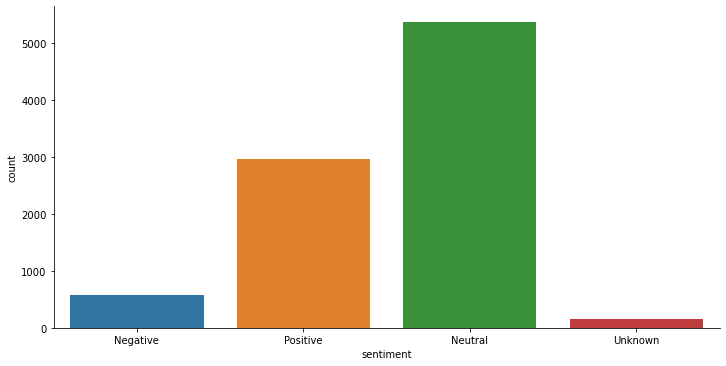

In [13]:
## Overall sentiment distribution
sns.catplot(data=df,x='sentiment',kind='count',order=sentiment_order,aspect=2);

#### Examing the class distributions

In [14]:
df['sentiment'].value_counts()

Neutral     5373
Positive    2968
Negative     569
Unknown      156
Name: sentiment, dtype: int64

In [15]:
df['sentiment'].value_counts(normalize=True)

Neutral     0.592654
Positive    0.327377
Negative    0.062762
Unknown     0.017207
Name: sentiment, dtype: float64

Less than half of the tweets were classified as having any emotion. Of the tweets which were tagged as having an emotion, most were coded positive. About 3,000 tweets compared to only 570 tweets that were tagged as having negative emotion.

In [16]:
df[df['sentiment']=='Unknown']

,text,product,sentiment
90,Thanks to @mention for publishing the news of ...,NaN,Unknown
102,ÛÏ@mention &quot;Apple has opened a pop-up st...,NaN,Unknown
237,Just what America needs. RT @mention Google to...,NaN,Unknown
341,The queue at the Apple Store in Austin is FOUR...,NaN,Unknown
368,Hope it's better than wave RT @mention Buzz is...,NaN,Unknown
...,...,...,...
9020,It's funny watching a room full of people hold...,NaN,Unknown
9032,"@mention yeah, we have @mention , Google has n...",NaN,Unknown
9037,"@mention Yes, the Google presentation was not ...",NaN,Unknown
9058,&quot;Do you know what Apple is really good at...,NaN,Unknown


These tweets labeled as unknown are difficult to classify without more context and could be viewed as sarcastic.
All tweets in the corpus will need to be classified for modeling later on and the volume accounts for less than 2% of the corpus it is safe to drop these records.

In [17]:
df = df[df['sentiment']!='Unknown']
df['sentiment'].value_counts(normalize=True)

Neutral     0.603030
Positive    0.333109
Negative    0.063861
Name: sentiment, dtype: float64

Since the business problem we are looking to solve requires understanding differences between positive and negative sentiments, it is essential that posiitive and negative twwets are separated for the exploration process.

In [24]:
# fig, ax = plt.subplots(figsize=(12,8))
# freq.plot(25);

# ## Rotate 
# ax.set_xticklabels(ax.get_xticklabels(),
#                    rotation=45,ha='right');
# fig.show();

In [22]:
# ## Get the most_common 100 and make into a dataframe
# most_common = pd.DataFrame(freq.most_common(100),
#                            columns=['word','count']).sort_values('count',
#                                                                  ascending=True)
# most_common.set_index('word').tail(25).plot(kind='barh',figsize=(12,5))

NameError: name 'freq' is not defined

In [ ]:
# def plot_most_common(freq,n=25,figsize=(12,5)):
#     most_common = pd.DataFrame(freq.most_common(n),
#                            columns=['word','count']).sort_values('count',
#                                                                  ascending=True)
#     most_common.set_index('word').tail(n).plot(kind='barh',figsize=figsize)
    
# plot_most_common(freq)

In [ ]:
## Make a new freq dist for tweet tokens and plot most common
tweet_freq = FreqDist(tweet_tokens)
plot_most_common(tweet_freq)

In [ ]:
positive_df = df.loc[df['sentiment']=='Positive']
positive_df

In [ ]:
negative_df = df.loc[df['sentiment']=='Negative']
negative_df

In [27]:
positive_corpus = positive_df['text'].to_list()
positive_corpus[:5]

NameError: name 'positive_df' is not defined

In [ ]:
negative_corpus = negative_df['text'].to_list()
negative_corpus[:5]

### Tokenization

In [25]:
from nltk import TweetTokenizer
import string

#Function for tokenization of tweets
def tweets_tokenize(corpus, preserve_case=False, strip_handles=True):
    
    tokenizer = TweetTokenizer(preserve_case=preserve_case, 
                               strip_handles=strip_handles)
    tokens = tokenizer.tokenize(','.join(corpus))
    
    return tokens

In [26]:
#positive tweets tokenized
positive_tokens = tweets_tokenize(positive_corpus)

NameError: name 'positive_corpus' is not defined

In [21]:
#negative tweets tokenized
negative_tokens = tweets_tokenize(negative_corpus)

NameError: name 'negative_corpus' is not defined

In [ ]:
#checking the most common positive tokens
from nltk import FreqDist
freq = FreqDist(positive_tokens)
freq.most_common(10)

In [ ]:
#checking the most common negative tokens
from nltk import FreqDist
freq = FreqDist(negative_tokens)
freq.most_common(10)

Looks like there are stop words and puncuations that were tokenized and will need to be removed. 

### Lemmatization

Before removing StopWords, tokens should be lemmatized to ensure the list of words are being captured

In [ ]:
from nltk.stem.wordnet import WordNetLemmatizer
#nltk.download('wordnet')

#Function for lemmatizating tokens
def lemmatize_tokens(tokens_list):
    
    lemmatizer = WordNetLemmatizer()
    lemma_tokens = [lemmatizer.lemmatize(word) for word in tokens_list]
    return lemma_tokens

In [ ]:
#Lemmatize positive tokens
positive_tokens_lemma = lemmatize_tokens(positive_tokens)

In [ ]:
#Lemmatize negative tokens
negative_tokens_lemma = lemmatize_tokens(negative_tokens)

### Punctuation And StopWord Removal

In [ ]:
#Import nltk's stopwords and add punctuation
from nltk.corpus import stopwords
stopword_list = stopwords.words('english')
stopword_list += list(string.punctuation)
#additional punctuation characters 
add_punct = ['“','”','...',"''",'’','``','']
stopword_list += add_punct

In [ ]:
#Function to remove of StopWords
def stopword_removal(tokens, stopword_list=stopword_list):
    
    #encoding tokens to remove unrecognized characters and url links
    stopped_tokens = [w.encode('ascii','ignore').decode() for w in tokens 
                      if (w not in stopword_list) & 
                      (w.startswith('http') == False)]
    
    return stopped_tokens

In [ ]:
#Removing StopWords from lemmatized tokens
positive_lemma_stopped = stopword_removal(positive_tokens_lemma)

In [ ]:
#Removing StopWords from lemmatized tokens
negative_lemma_stopped = stopword_removal(negative_tokens_lemma)

In [ ]:
#looking at the most common tokens
freq = FreqDist(positive_lemma_stopped)
freq.most_common(30)

In [ ]:
#looking at the most common tokens
freq = FreqDist(negative_lemma_stopped)
freq.most_common(30)

In [ ]:
# Appending stopwords list
stopword_list.extend(['rt','co','sxsw', '#sxsw', '#sxswi','link'])


In [ ]:
#Removing StopWords from lemmatized tokens
positive_lemma_stopped = stopword_removal(positive_tokens_lemma)

In [ ]:
#Removing StopWords from lemmatized tokens
negative_lemma_stopped = stopword_removal(negative_tokens_lemma)

In [ ]:
#looking at the most common tokens
freq = FreqDist(positive_lemma_stopped)
freq.most_common(30)

In [ ]:
#looking at the most common tokens
freq = FreqDist(negative_lemma_stopped)
freq.most_common(30)

### WordCloud Visualizations

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


def wordcloud_generator(tokens, collocations=False, background_color='black', 
                       colormap='Greens', display=True):

    
    # Initalize a WordCloud
    wordcloud = WordCloud(collocations=collocations, 
                          background_color=background_color, 
                          colormap=colormap, 
                          width=500, height=300)

    # Generate wordcloud from tokens
    wordcloud.generate(','.join(tokens))

    # Plot with matplotlib
    if display:
        plt.figure(figsize = (12, 15), facecolor = None) 
        plt.imshow(wordcloud) 
        plt.axis('off');
        
    return wordcloud

In [ ]:
#generate a WordCloud for positive tweets
positive_cloud = wordcloud_generator(positive_lemma_stopped, collocations=True)

In [ ]:
#generate a WordCloud for negative tweets
negative_cloud = wordcloud_generator(negative_lemma_stopped, colormap='Reds',
                                     collocations=True)

In [ ]:
def wordcloud_comp(wc1, wc2):
 
    fig, ax = plt.subplots(figsize=(30,20), ncols=2)
    ax[0].imshow(wc1)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].imshow(wc2)
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    plt.tight_layout();

In [ ]:
wordcloud_comp(positive_cloud, negative_cloud)

It looks like the brands presenting new services and  and product launches at the event appeared most in both positive and negative tweets. Let's look at WordClouds with those words added to the stop list.

In [ ]:
#removing brands and products from the Wordcloud
stopword_list_no_brands = stopword_list + ['ipad', 'ipad2','#ipad2','apple', 'google', 'iphone', 
                           '#apple','#google', '#ipad', '#iphone', 'android']

positive_stopped_brands = stopword_removal(positive_tokens_lemma, stopword_list=stopword_list_no_brands)

In [ ]:
negative_stopped_brands = stopword_removal(negative_tokens_lemma, stopword_list=stopword_list_no_brands)

In [ ]:
positive_cloud_no_names = wordcloud_generator(positive_stopped_brands, collocations=True)

In [ ]:
negative_cloud_no_names = wordcloud_generator(negative_stopped_brands, 
                                              colormap='Reds',collocations=True)

In [ ]:
wordcloud_comp(positive_cloud_no_names,negative_cloud_no_names)

###  Tweet Bigrams

In [ ]:
from nltk.collocations import *
bigram_measures = nltk.collocations.BigramAssocMeasures()

In [ ]:
positive_finder = BigramCollocationFinder.from_words(positive_lemma_stopped)

In [ ]:
bigrams = positive_finder.score_ngrams(bigram_measures.raw_freq)

In [ ]:
#top 30 bigrams
bigrams[:30]

### Exploring Sentiments of Products/Services

In [ ]:
df['product'].value_counts()

In [ ]:
product_order = ['iPad','Apple','iPad or iPhone App','Google','iPhone',
                 'Other Google product or service','Android App','Android',
                 'Other Apple product or service']

In [ ]:
# Product tweet distribution
sns.catplot(data=df,x='product',kind='count',order=product_order,aspect=3.5);

In [ ]:
#mapping products and services to their brand
product_dict={'iPad': 'Apple', 'Apple': 'Apple', 'iPad or iPhone App': 'Apple', 
              'Google': 'Google', 'iPhone': 'Apple', 
              'Other Google product or service': 'Google',
              'Android App': 'Google', 'Android': 'Google',
              'Other Apple product or service': 'Apple'}

df['brand'] = df['product'].map(product_dict)

In [ ]:
# Brand tweet distribution
sns.catplot(data=df,x='brand',kind='count',order=['Apple', 'Google'],aspect=3.5);

In [ ]:
df.groupby(['brand','product','sentiment']).count()

## Tweet Length

In [ ]:
def count_words(doc):
    tokenizer_no_strip = TweetTokenizer(strip_handles=False)
    tokens = tokenizer_no_strip.tokenize(doc)
    return len(tokens)

df['token_count'] = df['text'].map(lambda x: count_words(x))
df.head()

In [ ]:
# visualize distribution of tweet lengths 
with sns.plotting_context(context='talk'):
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.histplot(df['token_count'], color='lightblue', ax=ax)
    ax.set_title('Distribution of Tweet Lengths')
    ax.set_xlabel('Number of Tokens in Tweet');

### Bag of Words Stats

In [ ]:
import nltk
bigram_measures = nltk.collocations.BigramAssocMeasures()
tweet_finder = nltk.BigramCollocationFinder.from_words(stopped_tokens)
tweets_scored = tweet_finder.score_ngrams(bigram_measures.raw_freq)

In [ ]:
# Make a DataFrame from the Bigrams
pd.DataFrame(tweets_scored, columns=["Word","Freq"]).head(10)

In [ ]:
bigram_measures = nltk.collocations.BigramAssocMeasures()

tweet_pmi_finder = nltk.BigramCollocationFinder.from_words(stopped_tokens)
tweet_pmi_finder.apply_freq_filter(3)

tweet_pmi_scored = tweet_pmi_finder.score_ngrams(bigram_measures.pmi)

In [ ]:
# Make a DataFrame from the Bigrams with PMI
pd.DataFrame(tweet_pmi_scored,columns=['Words','PMI']).head(20)

# MODEL

#### Classification Evaluator

In [28]:
from sklearn.metrics import classification_report, plot_roc_curve, plot_confusion_matrix, roc_curve

def clf_eval(y_true, y_pred, X_test, X_train, clf, n_class=3):
    
    
    print(f"Training Score: {round(clf.score(X_train, y_train),2)} \
            Test Score:{round(clf.score(X_test, y_true),2)}")
    
   
    print("\n")
    print("Classification Report")
    print("------------------------------------------")
    print(classification_report(y_true=y_true, y_pred=y_pred))
    
    
    fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
    
    plot_confusion_matrix(estimator=clf, X=X_test, y_true=y_true, cmap='Blues', 
                          normalize='true', ax=ax[0], 
                          display_labels=['Negative','Neutral', 'Positive'])
 
    pred_prob = clf.predict_proba(X_test)

    
    
 
    try:
        roc_curve = metrics.plot_roc_curve(clf,X_test_tf,y_test,ax=ax[1])
        curve.ax_.grid()
        curve.ax_.plot([0,1],[0,1],ls=':')
        fig.tight_layout()
    except:
        fig.delaxes(ax[1])
    plt.show()
        

#### Train Test Split

In [29]:
y = df['sentiment']
X = df['text']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

NameError: name 'train_test_split' is not defined

In [ ]:
# wirte function for pipelines
#bagogwords/tdidf

#### Baseline Model

Baseline model will be used to measure how well our model performs compared to random guessing.

In [ ]:
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True)

In [ ]:
from sklearn.dummy import DummyClassifier

clf_pipe = Pipeline([('vectorizer', TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                                    stop_words=stopword_list)),
                     ('clf', DummyClassifier(random_state=42))])

clf_pipe.fit(X_train, y_train)
y_pred = clf_pipe.predict(X_test)
clf_eval(y_test, y_pred, X_test, X_train, clf_pipe)



## Naive Bayes


In [ ]:
from sklearn.naive_bayes import MultinomialNB

mnb_text_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                   stop_words=stopword_list)),
    ('clf', MultinomialNB())
])

In [ ]:
mnb_text_pipe.fit(X_train, y_train)
y_pred = mnb_text_pipe.predict(X_test)
clf_eval(y_test, y_pred, X_test, X_train, mnb_text_pipe)

## Logistic Regression

In [ ]:
lr_text_pipe = Pipeline([('vectorizer', TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                   stop_words=stopword_list)), 
    ('clf', LogisticRegressionCV(solver='saga',max_iter=500, class_weight='balanced', random_state=42,n_jobs=-1))
])

In [ ]:
lr_text_pipe.fit(X_train, y_train)
y_pred = lr_text_pipe.predict(X_test)
clf_eval(y_test, y_pred, X_test, X_train, lr_text_pipe)

#### Hyperparameter Tuning with GridSearchCV

In [ ]:
param_grid = {'clf__class_weight': ['balanced'],
              'clf__max_iter': [100, 500, 1000],
              'clf__Cs': [[0.01], [0.1], [1]],
              'clf__solver': ['liblinear', 'lbfgs', 'sag', 'saga']}

gs = GridSearchCV(estimator=lr_text_pipe, param_grid = param_grid, 
                              scoring='recall_macro')

gs.fit(X_train,  y_train)
gs.best_params_

### Tuned LR Model

In [ ]:
tuned_lr_text_pipe = Pipeline([('vectorizer', TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                   stop_words=stopword_list)), 
    ('clf', LogisticRegressionCV(solver='liblinear',
                                 max_iter=100, 
                                 class_weight='balanced',
                                 Cs=1,
                                 random_state=42,
                                 n_jobs=-1))
])

In [ ]:
tuned_lr_text_pipe.fit(X_train, y_train)
y_pred = tuned_lr_text_pipe.predict(X_test)
clf_eval(y_test, y_pred, X_test, X_train, tuned_lr_text_pipe)

## RandomForest

In [ ]:
rf_text_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                   stop_words=stopword_list)), 
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

In [ ]:
rf_text_pipe.fit(X_train, y_train)
y_pred = rf_text_pipe.predict(X_test)
clf_eval(y_test, y_pred, X_test, X_train, rf_text_pipe)

# Interpreting Results

## Best Model

Evaluate how well your work solves the stated business problem.



***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

In [ ]:
def plot_importance(clf_pipe, n_features, title):
   
    feats = clf_pipe['vectorizer'].get_feature_names()
    coefs = clf_pipe['clf'].coef_[0]
    
    importance_df = pd.DataFrame(feats, columns=['Word'])
    importance_df['Importance'] = math.e**(abs(coefs))
    importance_df['Coefficient'] = coefs

    feat_importance = importance_df.sort_values(by = ["Importance"], 
                                                   ascending=False).head(n_features)
    
    fig, ax = plt.subplots(figsize=(15,10), ncols=2)
    ax[0].set_title(f'Coefficients for {title}')
    ax[0].set_ylabel('Word')
    ax[0].set_xlabel('Coefficient')
    sns.barplot(x='Coefficient', y='Word', palette='magma', data=feat_importance, ax=ax[0])

    ax[1].set_title(f'Feature Importances for {title}')
    ax[1].set_ylabel('Word')
    ax[1].set_xlabel('Importance')
    sns.barplot(x='Importance', y='Word', palette='magma', data=feat_importance, ax=ax[1])
    plt.tight_layout();

In [ ]:
plot_importance(lr_text_pipe, 15, 'Tuned Logistic Regression Model')

# CONCLUSIONS & RECOMMENDATIONS

## Recommendations

## Limitations & Next Steps